In [ ]:
# Initialize Modin and Joblib for parallel and distributed processing
import os
os.environ["MODIN_ENGINE"] = "ray"  # Use Ray as Modin backend
import modin.pandas as pd
import joblib
import warnings
warnings.filterwarnings('ignore')

# Now, use 'pd' as you would with pandas, but with distributed execution

# Parallel and Distributed Data Processing with Modin and Joblib
This notebook leverages Modin and Joblib libraries to accelerate data processing and model training:

- **Modin** is used as a drop-in replacement for pandas to enable distributed and parallel data manipulation, making it possible to process large datasets efficiently across multiple CPU cores or clusters.
- **Joblib** is used to parallelize model training and evaluation, enabling efficient use of computational resources during machine learning workflows.

To use Modin, simply replace `import pandas as pd` with `import modin.pandas as pd`. Modin can be configured to run on Ray or Dask backends for distributed execution.

In [ ]:


ton_iot = pd.read_csv('NF-BoT-IoT-v2.csv')
ton_iot.shape

(37763497, 45)

## Correlation

In [2]:
categorical_feature = ['L4_SRC_PORT','L4_DST_PORT','IPV4_SRC_ADDR',
                       'IPV4_DST_ADDR','PROTOCOL','L7_PROTO','DNS_QUERY_TYPE','ICMP_TYPE'
                        ,'ICMP_IPV4_TYPE','DNS_TTL_ANSWER']

not_used = ['DNS_QUERY_ID','FTP_COMMAND_RET_CODE']

tagets = ['Attack','Label']

to_drop = categorical_feature+not_used+tagets

X_corr_vif = ton_iot.drop(columns=to_drop)

In [3]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)
corr = X_corr_vif.corr()
corr.style.background_gradient(cmap='coolwarm')

,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT
IN_BYTES,1.000000,0.855326,0.370988,0.604972,-0.000720,0.001128,-0.000325,0.001179,-0.001573,0.010073,0.014105,0.014105,0.165306,0.022248,0.047363,0.165306,0.017142,0.004632,0.040199,0.039902,0.000223,0.000016,0.862612,0.296703,0.051222,0.200677,0.511532,0.823033,0.800009,0.000967,0.000574
IN_PKTS,0.855326,1.000000,0.413094,0.638092,-0.003437,-0.001049,-0.002794,0.004029,0.000497,0.010947,0.021680,0.021680,0.072113,0.023623,0.048819,0.072113,0.019255,0.005057,0.148488,0.148421,0.005254,0.001714,0.742289,0.328259,0.264011,0.241739,0.643802,0.908562,0.877931,0.001460,0.000757
OUT_BYTES,0.370988,0.413094,1.000000,0.687861,0.000770,0.003760,0.001181,0.000383,-0.001655,0.010807,0.006173,0.006173,0.228523,0.010213,0.050857,0.228523,0.009022,0.004807,-0.000012,-0.000022,0.134889,0.045667,0.325604,0.638656,0.062137,0.038331,0.333676,0.525443,0.561698,0.004077,0.000377
OUT_PKTS,0.604972,0.638092,0.687861,1.000000,0.005154,0.004590,0.005449,-0.002214,-0.003324,0.018761,0.007098,0.007098,0.062024,0.015431,0.085206,0.062024,0.014703,0.007845,0.000000,-0.000027,0.042288,0.016490,0.529625,0.547394,0.014717,0.006517,0.529842,0.838314,0.892643,0.005050,0.003636
TCP_FLAGS,-0.000720,-0.003437,0.000770,0.005154,1.000000,0.557583,0.980696,-0.456823,-0.237137,0.166494,-0.520942,-0.520938,0.268101,-0.096516,0.951855,0.268101,-0.000359,-0.000113,-0.000444,-0.000121,0.039137,0.050598,0.040683,0.054585,0.001875,0.063131,-0.001196,-0.001600,-0.001644,0.334230,0.505706
CLIENT_TCP_FLAGS,0.001128,-0.001049,0.003760,0.004590,0.557583,1.000000,0.437032,-0.210512,-0.025160,0.232746,-0.117827,-0.117799,0.550929,0.281362,0.458619,0.550929,-0.000395,-0.000125,0.000944,0.002523,0.104699,0.134924,0.100879,0.087210,-0.002313,0.151181,-0.000186,-0.001329,-0.001629,0.810464,0.541542
SERVER_TCP_FLAGS,-0.000325,-0.002794,0.001181,0.005449,0.980696,0.437032,1.000000,-0.466778,-0.283830,0.113934,-0.527201,-0.527208,0.185421,-0.225348,0.957396,0.185421,-0.000267,-0.000085,-0.000865,-0.001196,0.009697,0.011483,0.025725,0.056098,0.007635,0.011049,-0.000804,-0.001137,-0.001197,0.260703,0.475859
FLOW_DURATION_MILLISECONDS,0.001179,0.004029,0.000383,-0.002214,-0.456823,-0.210512,-0.466778,1.000000,0.495484,0.017449,0.851186,0.851175,-0.025738,0.071212,-0.438382,-0.025738,0.000197,0.000062,0.001736,0.003004,0.003662,0.004862,-0.019302,-0.035270,-0.002371,0.071542,0.000695,0.000857,0.000918,-0.196984,-0.043722
DURATION_IN,-0.001573,0.000497,-0.001655,-0.003324,-0.237137,-0.025160,-0.283830,0.495484,1.000000,0.016070,0.537427,0.537411,0.201976,0.414145,-0.274775,0.201976,0.001575,0.000992,0.002610,0.006237,-0.018015,-0.023022,0.054109,-0.022517,-0.016673,0.224354,-0.002072,-0.002061,-0.002007,-0.119633,-0.083437
DURATION_OUT,0.010073,0.010947,0.010807,0.018761,0.166494,0.232746,0.113934,0.017449,0.016070,1.000000,-0.049057,-0.049058,0.061782,-0.033320,0.193050,0.061782,0.007324,0.007323,-0.000040,0.000030,0.239536,0.316453,-0.001908,0.009087,0.004628,0.017825,0.007366,0.014562,0.015068,0.287545,0.168154


In [4]:
import numpy as np

ton_corr_tmp = ['SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_OUT_PKTS']
# MAX_IP_PKT_LEN with LONGEST_FLOW_PKT
    
cor_matrix = corr.abs()

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.94)]
to_drop_corr

['SERVER_TCP_FLAGS',
 'MAX_TTL',
 'MIN_IP_PKT_LEN',
 'MAX_IP_PKT_LEN',
 'RETRANSMITTED_IN_PKTS',
 'NUM_PKTS_1024_TO_1514_BYTES']

# Preprocessing 

## rank the feature by high correlation 

In [ ]:
import numpy as np
cor_matrix = X_corr_vif.corr().abs()

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#print(upper_tri)

In [ ]:
to_drop_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.94)]
print(to_drop_corr)

### Select the feature to drop with correlaion upper than 94%

In [10]:
X_corr_vif.drop(columns=to_drop_corr, axis=1, inplace=True)


KeyError: "['SERVER_TCP_FLAGS', 'MAX_TTL', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_IN_PKTS', 'NUM_PKTS_1024_TO_1514_BYTES'] not found in axis"

In [9]:
X_corr_vif.shape

(37763497, 25)

**We have 4 features to drop are  are '['SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_OUT_PKTS']
**

In [ ]:
print(f' original data {len(X_corr_vif.columns)}')
ton_iot.drop(columns=to_drop_corr, axis=1, inplace=True)
ton_iot.drop(columns=not_used)
print(len(X_corr_vif.columns))
print((X_corr_vif.columns))


## Using VIF for numerical feature 

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_corr_vif['SRC_TO_DST_SECOND_BYTES'] = X_corr_vif['SRC_TO_DST_SECOND_BYTES'].astype(int)
X_corr_vif['DST_TO_SRC_SECOND_BYTES'] = X_corr_vif['DST_TO_SRC_SECOND_BYTES'].astype(int)

X_scaled_red = pd.DataFrame()
scaler.fit(X_corr_vif)

X_scaled_red[X_corr_vif.columns] = scaler.transform(X_corr_vif)

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import shuffle


#shuffled = shuffle(X_scaled_red)
#X_scaled_red = shuffled[:2000000]

vif_scores = [variance_inflation_factor(X_scaled_red.values, feature)for feature in range(len(X_scaled_red.columns))]
vif = pd.DataFrame()
vif["features"] = X_scaled_red.columns
vif["VIF Factor"] = vif_scores
vif.sort_values(by=['VIF Factor'])

,features,VIF Factor
13,DST_TO_SRC_SECOND_BYTES,1.265307
12,SRC_TO_DST_SECOND_BYTES,1.279764
8,DURATION_OUT,1.284123
20,NUM_PKTS_128_TO_256_BYTES,1.667731
7,DURATION_IN,1.941050
18,DST_TO_SRC_AVG_THROUGHPUT,2.500458
24,TCP_WIN_MAX_OUT,2.559331
2,OUT_BYTES,3.009774
4,TCP_FLAGS,3.381916
11,SHORTEST_FLOW_PKT,3.391649


In [13]:
vif_col = []

COLUMN = 'NUM_PKTS_512_TO_1024_BYTES'
vif_col.append(COLUMN)

X_scaled_red.drop(columns=[COLUMN], inplace=True)
vif_scores = [variance_inflation_factor(X_scaled_red.values, feature)for feature in range(len(X_scaled_red.columns))]
vif = pd.DataFrame()
vif["features"] = X_scaled_red.columns
vif["VIF Factor"] = vif_scores
vif.sort_values(by=['VIF Factor'])

,features,VIF Factor
13,DST_TO_SRC_SECOND_BYTES,1.264785
12,SRC_TO_DST_SECOND_BYTES,1.279171
8,DURATION_OUT,1.282966
19,NUM_PKTS_UP_TO_128_BYTES,1.461732
20,NUM_PKTS_128_TO_256_BYTES,1.463027
7,DURATION_IN,1.941011
18,DST_TO_SRC_AVG_THROUGHPUT,2.438204
23,TCP_WIN_MAX_OUT,2.559301
2,OUT_BYTES,2.727338
11,SHORTEST_FLOW_PKT,3.349286


['NUM_PKTS_512_TO_1024_BYTES']

In [15]:
COLUMN = 'NUM_PKTS_256_TO_512_BYTES'
vif_col.append(COLUMN)

X_scaled_red.drop(columns=[COLUMN], inplace=True)
vif_scores = [variance_inflation_factor(X_scaled_red.values, feature)for feature in range(len(X_scaled_red.columns))]
vif = pd.DataFrame()
vif["features"] = X_scaled_red.columns
vif["VIF Factor"] = vif_scores
vif.sort_values(by=['VIF Factor'])

,features,VIF Factor
14,RETRANSMITTED_IN_BYTES,1.094773
13,DST_TO_SRC_SECOND_BYTES,1.262776
12,SRC_TO_DST_SECOND_BYTES,1.277461
8,DURATION_OUT,1.282964
19,NUM_PKTS_UP_TO_128_BYTES,1.333430
20,NUM_PKTS_128_TO_256_BYTES,1.399100
7,DURATION_IN,1.940722
18,DST_TO_SRC_AVG_THROUGHPUT,2.428708
22,TCP_WIN_MAX_OUT,2.559263
2,OUT_BYTES,2.715511


In [16]:
COLUMN = 'CLIENT_TCP_FLAGS'
vif_col.append(COLUMN)

X_scaled_red.drop(columns=[COLUMN], inplace=True)
vif_scores = [variance_inflation_factor(X_scaled_red.values, feature)for feature in range(len(X_scaled_red.columns))]
vif = pd.DataFrame()
vif["features"] = X_scaled_red.columns
vif["VIF Factor"] = vif_scores
vif.sort_values(by=['VIF Factor'])

,features,VIF Factor
13,RETRANSMITTED_IN_BYTES,1.094631
12,DST_TO_SRC_SECOND_BYTES,1.259440
11,SRC_TO_DST_SECOND_BYTES,1.274480
7,DURATION_OUT,1.278754
18,NUM_PKTS_UP_TO_128_BYTES,1.333428
19,NUM_PKTS_128_TO_256_BYTES,1.398697
20,TCP_WIN_MAX_IN,1.541831
21,TCP_WIN_MAX_OUT,1.820923
6,DURATION_IN,1.935890
17,DST_TO_SRC_AVG_THROUGHPUT,2.427187


In [17]:
COLUMN = 'IN_BYTES'
vif_col.append(COLUMN)

X_scaled_red.drop(columns=[COLUMN], inplace=True)
vif_scores = [variance_inflation_factor(X_scaled_red.values, feature)for feature in range(len(X_scaled_red.columns))]
vif = pd.DataFrame()
vif["features"] = X_scaled_red.columns
vif["VIF Factor"] = vif_scores
vif.sort_values(by=['VIF Factor'])

,features,VIF Factor
12,RETRANSMITTED_IN_BYTES,1.071147
17,NUM_PKTS_UP_TO_128_BYTES,1.241921
11,DST_TO_SRC_SECOND_BYTES,1.259423
10,SRC_TO_DST_SECOND_BYTES,1.274431
6,DURATION_OUT,1.276896
18,NUM_PKTS_128_TO_256_BYTES,1.397048
19,TCP_WIN_MAX_IN,1.516546
20,TCP_WIN_MAX_OUT,1.820888
5,DURATION_IN,1.933885
16,DST_TO_SRC_AVG_THROUGHPUT,2.143722


In [18]:
vif_col

['NUM_PKTS_512_TO_1024_BYTES',
 'NUM_PKTS_256_TO_512_BYTES',
 'CLIENT_TCP_FLAGS',
 'IN_BYTES']

Shuffle the big class and apply the undersampling 

### Visualize data with profilling data 

In [2]:
not_used = ['DNS_QUERY_ID','FTP_COMMAND_RET_CODE']
to_drop_corr_col = ['SERVER_TCP_FLAGS','MAX_TTL','MIN_IP_PKT_LEN','MAX_IP_PKT_LEN','RETRANSMITTED_IN_PKTS','NUM_PKTS_1024_TO_1514_BYTES']
to_drop_VIF =['NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_256_TO_512_BYTES','CLIENT_TCP_FLAGS', 'IN_BYTES']

to_drop_profile = not_used+to_drop_corr_col+to_drop_VIF

data_profile = ton_iot_copy.drop(columns=to_drop_profile)

NameError: name 'ton_iot_copy' is not defined

In [20]:
from pandas_profiling import ProfileReport
profile_ton = ProfileReport(data_profile, minimal=True)
profile_ton

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## discretization of the numerical values

### Choose the number of cluster

In [21]:
from sklearn.preprocessing import KBinsDiscretizer

kmeans_disc = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy='quantile')



### Deletes features from 

In [3]:
categorical_feature = ['L4_SRC_PORT','L4_DST_PORT','IPV4_SRC_ADDR',
                       'IPV4_DST_ADDR','PROTOCOL','L7_PROTO','DNS_QUERY_TYPE','ICMP_TYPE'
                        ,'ICMP_IPV4_TYPE','DNS_TTL_ANSWER']

not_used = ['DNS_QUERY_ID','FTP_COMMAND_RET_CODE']

tagets = ['Attack','Label']

to_drop_corr_col = ['SERVER_TCP_FLAGS','MAX_TTL','MIN_IP_PKT_LEN','MAX_IP_PKT_LEN','RETRANSMITTED_IN_PKTS','NUM_PKTS_1024_TO_1514_BYTES']

to_drop_VIF =['NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_256_TO_512_BYTES','CLIENT_TCP_FLAGS', 'IN_BYTES']

to_drop = categorical_feature+not_used+tagets + to_drop_corr_col + to_drop_VIF

X_Numerical = ton_iot.drop(columns=to_drop)




In [4]:
X_Numerical.shape

(37763497, 21)

## Discriritization of Numerical value using  quantile

In [5]:
from sklearn.preprocessing import KBinsDiscretizer

qtl_disc = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy='quantile')

X_Num_disc = pd.DataFrame()

qtl_disc.fit(X_Numerical)

X_Num_disc[X_Numerical.columns] = qtl_disc.transform(X_Numerical)

In [6]:
X_Num_disc = X_Num_disc.astype(int)

X_Num_disc.shape

(37763497, 21)

In [7]:
X_Num_disc.LONGEST_FLOW_PKT.value_counts()

LONGEST_FLOW_PKT
0    18392763
2    17866999
1     1503735
Name: count, dtype: int64

In [8]:
X_cat = ton_iot[categorical_feature]

In [9]:
X_cat.shape

(37763497, 10)

# Optimize the features

### L4_SRC_PORT & L4_DST_PORT

Ports with numbers 0–1023 are called system or well-known ports; ports with numbers 1024-49151 are called user or registered ports, and ports with numbers 49152-65535 are called dynamic, private or ephemeral ports.[2] Both system and user ports are used by transport protocols (TCP, UDP, DCCP, SCTP) to identify an application or service.

In [10]:
well_known_port = list(range(1024))
registered_ports = list(range(1024,49152))
ephemeral_ports = list(range(49152,65535))

In [11]:
X_cat['L4_SRC_PORT_C'] = 'Others'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(well_known_port)] = 'well_known_port'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(registered_ports)] = 'registered_ports'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(ephemeral_ports)] = 'ephemeral_ports'

X_cat.drop(columns=['L4_SRC_PORT'],inplace=True)

X_cat['L4_SRC_PORT_C'].value_counts()

print(X_cat.shape)

(37763497, 10)


In [12]:
X_cat['L4_DST_PORT_C'] = 'Others'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(well_known_port)] = 'well_known_port'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(registered_ports)] = 'registered_ports'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(ephemeral_ports)] = 'ephemeral_ports'

X_cat.drop(columns=['L4_DST_PORT'],inplace=True)
X_cat['L4_DST_PORT_C'].value_counts()


L4_DST_PORT_C
well_known_port     36216410
registered_ports     1229256
ephemeral_ports       317386
Others                   445
Name: count, dtype: int64

#### Removerd features are :

to_drop_zero = ['RETRANSMITTED_IN_BYTES','RETRANSMITTED_IN_PKTS','RETRANSMITTED_OUT_BYTES','FTP_COMMAND_RET_CODE','ICMP_TYPE','DNS_TTL_ANSWER']
&&

['SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_OUT_PKTS', 'ICMP_IPV4_TYPE']

## DNS

In [13]:
X_cat['DNS_QUERY_TYPE'] = X_cat['DNS_QUERY_TYPE'].astype('O')
list_proto = [0]
X_cat['DNS_QUERY_TYPE'][~X_cat['DNS_QUERY_TYPE'].isin(list_proto)] = 1
X_cat['DNS_QUERY_TYPE'].value_counts()

DNS_QUERY_TYPE
0    37756539
1        6958
Name: count, dtype: int64

### PROTOCOL

In [14]:
X_cat['PROTOCOL'] = X_cat['PROTOCOL'].astype(int)

X_cat['PROTOCOL'].value_counts()

PROTOCOL
6     19411243
17    18349697
1         2551
2            4
58           2
Name: count, dtype: int64

In [15]:
print(X_cat.shape)

(37763497, 10)


### L7_PROTO

In [16]:
X_cat['L7_PROTO'] = X_cat['L7_PROTO'].astype('O')
list_proto = [0,7,118]
X_cat['L7_PROTO'][~X_cat['L7_PROTO'].isin(list_proto)] = 'Other'
X_cat['L7_PROTO'].value_counts()

L7_PROTO
Other    18384705
7.0      17793435
0.0       1585357
Name: count, dtype: int64

#### Adresses

### Adress Range

In [17]:
# Private adresses
# Class A: 10.0.0.0 to 10.255.255.255
# Class B: 172.16.0.0 to 172.31.255.255
# Class C: 192.168.0.0 to 192.168.255.255
from ipaddress import ip_address


def findIPs(start, end):
    start = ip_address(start)
    end = ip_address(end)
    result = []
    while start <= end:
        result.append(str(start))
        start += 1
    return result
print('classe_a process ------------------------------->')
plage_classe_a=findIPs('10.0.0.0', '10.255.255.255')
print('classe_b process ------------------------------->')
plage_classe_b=findIPs('172.16.0.0', '172.31.255.255')
print('classe_c process ------------------------------->')
plage_classe_c=findIPs('192.168.0.0', '192.168.255.255')

classe_a process ------------------------------->
classe_b process ------------------------------->
classe_c process ------------------------------->


In [18]:
import numpy as np
X_cat['IPV4_DST_ADDR_CLASSE'] = 'None'
print('classe_c process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_c)] = 'classe_c'
print('classe_b process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_b)] = 'classe_b'
print('classe_a process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_a)] = 'classe_a'
print('localhost process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'] == '127.0.0.1'] = 'localhost'
print('public/other process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR_CLASSE'] == 'None'] = 'public/other'
X_cat['IPV4_DST_ADDR_CLASSE'].value_counts()

classe_c process ------------------------------->
classe_b process ------------------------------->
classe_a process ------------------------------->
localhost process ------------------------------->
public/other process ------------------------------->


IPV4_DST_ADDR_CLASSE
classe_c        37759084
public/other        4413
Name: count, dtype: int64

In [19]:
import numpy as np
X_cat['IPV4_SRC_ADDR_CLASSE'] = 'None'
print('classe_c process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_c)] = 'classe_c'
print('classe_b process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_b)] = 'classe_b'
print('classe_a process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_a)] = 'classe_a'
print('localhost process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'] == '127.0.0.1'] = 'localhost'
print('public/other process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR_CLASSE'] == 'None'] = 'public/other'
X_cat['IPV4_SRC_ADDR_CLASSE'].value_counts()

classe_c process ------------------------------->
classe_b process ------------------------------->
classe_a process ------------------------------->
localhost process ------------------------------->
public/other process ------------------------------->


IPV4_SRC_ADDR_CLASSE
classe_c        37763472
public/other          25
Name: count, dtype: int64

Remove IPV4_SRC_ADDR & IPV4_DST_ADDR and Keep IPV4_SRC_ADDR IPV4_DST_ADDR

In [20]:
X_cat.drop(columns=['IPV4_SRC_ADDR','IPV4_DST_ADDR'], inplace=True)

## Optimze the 3 features ICMP_TYPE, ICMP_IPV4_TYPE, DNS_TTL_ANSWER

In [21]:
import math
infini = math.inf

X_cat['ICMP_TYPE'] = X_cat['ICMP_TYPE'].astype('O')
X_cat['ICMP_IPV4_TYPE'] = X_cat['ICMP_IPV4_TYPE'].astype('O')
X_cat['DNS_TTL_ANSWER'] = X_cat['DNS_TTL_ANSWER'].astype('O')

X_cat['ICMP_TYPE'][~(X_cat['ICMP_TYPE']==0)]=1
X_cat['ICMP_IPV4_TYPE'][~(X_cat['ICMP_IPV4_TYPE']==0)]=1
X_cat['DNS_TTL_ANSWER'][~(X_cat['DNS_TTL_ANSWER']==0)]=1

print(f"ICMPTYPE {X_cat['ICMP_TYPE'].value_counts()}, \n ICMP_IPV4_TYPE  {X_cat['ICMP_IPV4_TYPE'].value_counts()}, \n  DNS_TTL_ANSWER  {X_cat['DNS_TTL_ANSWER'].value_counts()}")



ICMPTYPE ICMP_TYPE
0    32830438
1     4933059
Name: count, dtype: int64, 
 ICMP_IPV4_TYPE  ICMP_IPV4_TYPE
0    32830517
1     4932980
Name: count, dtype: int64, 
  DNS_TTL_ANSWER  DNS_TTL_ANSWER
0    37760796
1        2701
Name: count, dtype: int64


In [22]:
X_cat.head(4)

,PROTOCOL,L7_PROTO,DNS_QUERY_TYPE,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_TTL_ANSWER,L4_SRC_PORT_C,L4_DST_PORT_C,IPV4_DST_ADDR_CLASSE,IPV4_SRC_ADDR_CLASSE
0,6,7.0,0,0,0,0,ephemeral_ports,well_known_port,classe_c,classe_c
1,6,7.0,0,0,0,0,ephemeral_ports,well_known_port,classe_c,classe_c
2,6,7.0,0,0,0,0,registered_ports,well_known_port,classe_c,classe_c
3,17,Other,0,0,0,0,ephemeral_ports,well_known_port,classe_c,classe_c


# Feature Selection Filter-based

In [23]:
y_b = ton_iot['Label']

y_multi =  ton_iot['Attack']

ton_iot['Label'].value_counts()



Label
1    37628460
0      135037
Name: count, dtype: int64

In [24]:
print(X_Num_disc.shape)
print(X_cat.shape)



(37763497, 21)
(37763497, 10)


In [25]:
from sklearn.feature_selection import chi2

# Convert string values in categorical features to numerical
X_cat = X_cat.replace('Other',999)
X_cat = X_cat.replace('Others',999)
X_cat = X_cat.replace('well_known_port',0)
X_cat = X_cat.replace('registered_ports',1)
X_cat = X_cat.replace('ephemeral_ports',2)



X_cat = X_cat.replace('localhost',0)
X_cat = X_cat.replace('classe_a',1)
X_cat = X_cat.replace('classe_b',2)
X_cat = X_cat.replace('classe_c',3)
X_cat = X_cat.replace('public/other',4)


X_cat = X_cat.astype(int)


X = pd.concat([X_Num_disc, X_cat], axis=1)

#X.dropna(inplace=True)

X = X.astype(int)




(7552700, 31) (7552700,)


## Use chi2 to filter-based feature selection

In [27]:
chi2_corr = chi2(X,y_b)
columns_ranked_chi2 = list(X.columns[np.argsort(-chi2_corr[0])])
columns_ranked_chi2

['L7_PROTO',
 'L4_DST_PORT_C',
 'DNS_QUERY_TYPE',
 'OUT_BYTES',
 'DST_TO_SRC_SECOND_BYTES',
 'OUT_PKTS',
 'DST_TO_SRC_AVG_THROUGHPUT',
 'DNS_TTL_ANSWER',
 'DURATION_IN',
 'SRC_TO_DST_SECOND_BYTES',
 'PROTOCOL',
 'TCP_FLAGS',
 'FLOW_DURATION_MILLISECONDS',
 'L4_SRC_PORT_C',
 'IN_PKTS',
 'MIN_TTL',
 'NUM_PKTS_128_TO_256_BYTES',
 'NUM_PKTS_UP_TO_128_BYTES',
 'TCP_WIN_MAX_IN',
 'RETRANSMITTED_IN_BYTES',
 'ICMP_TYPE',
 'ICMP_IPV4_TYPE',
 'LONGEST_FLOW_PKT',
 'SRC_TO_DST_AVG_THROUGHPUT',
 'SHORTEST_FLOW_PKT',
 'IPV4_DST_ADDR_CLASSE',
 'IPV4_SRC_ADDR_CLASSE',
 'TCP_WIN_MAX_OUT',
 'RETRANSMITTED_OUT_PKTS',
 'RETRANSMITTED_OUT_BYTES',
 'DURATION_OUT']

In [30]:
len(columns_ranked_chi2)

31

## Ranking of features using CHI2

# We will select 3 pourcentage from the rest of the features
20 %  = 7

50 %  = 18

80 %  = 25

### Generate the 3 databases for chi 2

In [28]:
X_chi2_20 = X[columns_ranked_chi2[:7]]
X_chi2_50 =  X[columns_ranked_chi2[:18]]
X_chi2_80 =  X[columns_ranked_chi2[:25]]

dummy_feature = ['L4_SRC_PORT_C','L4_DST_PORT_C','IPV4_SRC_ADDR_CLASSE',
                 'IPV4_DST_ADDR_CLASSE','PROTOCOL','L7_PROTO']
list_dummy_20 = list(set( list(X_chi2_20.columns)).intersection(dummy_feature))
list_dummy_50 = list(set( list(X_chi2_50.columns)).intersection(dummy_feature))
list_dummy_80 = list(set( list(X_chi2_80.columns)).intersection(dummy_feature))


X_chi2_20 = pd.get_dummies(X_chi2_20, columns=list_dummy_20)
X_chi2_50 = pd.get_dummies(X_chi2_50, columns=list_dummy_50)
X_chi2_80 = pd.get_dummies(X_chi2_80, columns=list_dummy_80)

# MUTUAL INFORMATION

In [29]:
from sklearn.feature_selection import mutual_info_classif

mi_class = mutual_info_classif(X, y_b)


In [31]:
columns_ranked_mi = list(X.columns[np.argsort(-mi_class)])
columns_ranked_mi

['SRC_TO_DST_SECOND_BYTES',
 'IN_PKTS',
 'L4_SRC_PORT_C',
 'DURATION_IN',
 'FLOW_DURATION_MILLISECONDS',
 'PROTOCOL',
 'SRC_TO_DST_AVG_THROUGHPUT',
 'NUM_PKTS_UP_TO_128_BYTES',
 'TCP_FLAGS',
 'DST_TO_SRC_SECOND_BYTES',
 'OUT_PKTS',
 'OUT_BYTES',
 'DST_TO_SRC_AVG_THROUGHPUT',
 'ICMP_TYPE',
 'ICMP_IPV4_TYPE',
 'RETRANSMITTED_IN_BYTES',
 'L4_DST_PORT_C',
 'DNS_QUERY_TYPE',
 'DNS_TTL_ANSWER',
 'RETRANSMITTED_OUT_PKTS',
 'DURATION_OUT',
 'TCP_WIN_MAX_OUT',
 'SHORTEST_FLOW_PKT',
 'MIN_TTL',
 'RETRANSMITTED_OUT_BYTES',
 'LONGEST_FLOW_PKT',
 'NUM_PKTS_128_TO_256_BYTES',
 'TCP_WIN_MAX_IN',
 'L7_PROTO',
 'IPV4_DST_ADDR_CLASSE',
 'IPV4_SRC_ADDR_CLASSE']

In [49]:
mi_scores

array([9.31093099e-04, 3.28952238e-04, 8.08842679e-06, 5.89040619e-06,
       3.93630527e-06, 3.36984823e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

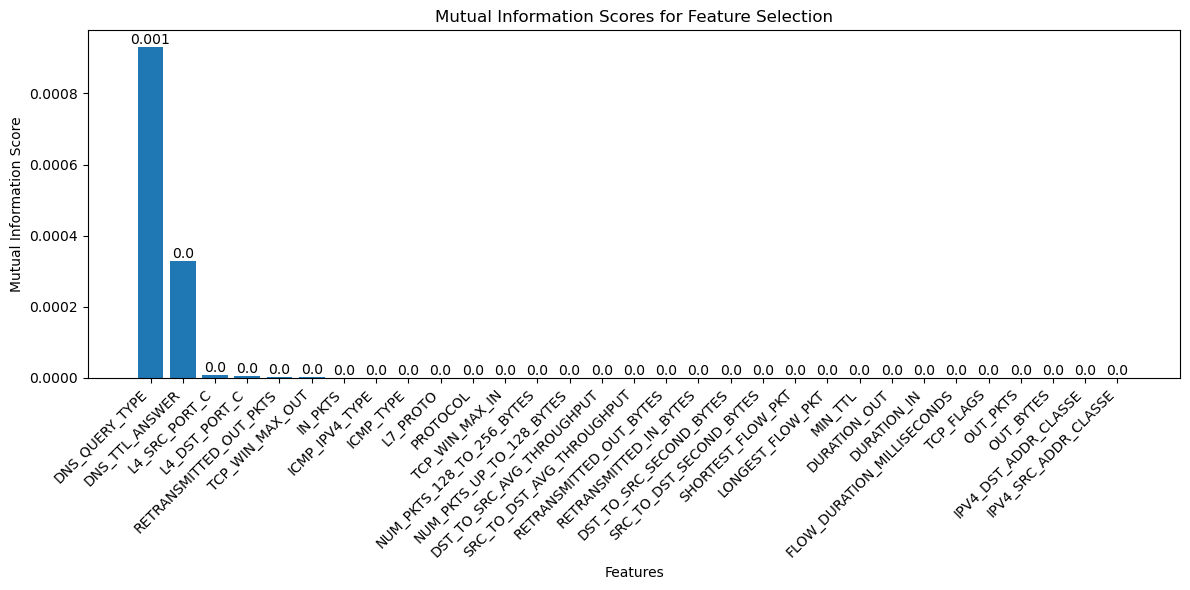

In [48]:
import matplotlib.pyplot as plt

mi_scores = -np.sort(-mi_class)
feature_names = columns_ranked_mi

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(feature_names)), mi_scores, align='center')
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.title("Mutual Information Scores for Feature Selection")

# Add MI score values at the top of each bar
for bar, score in zip(bars, mi_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(score, 3),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


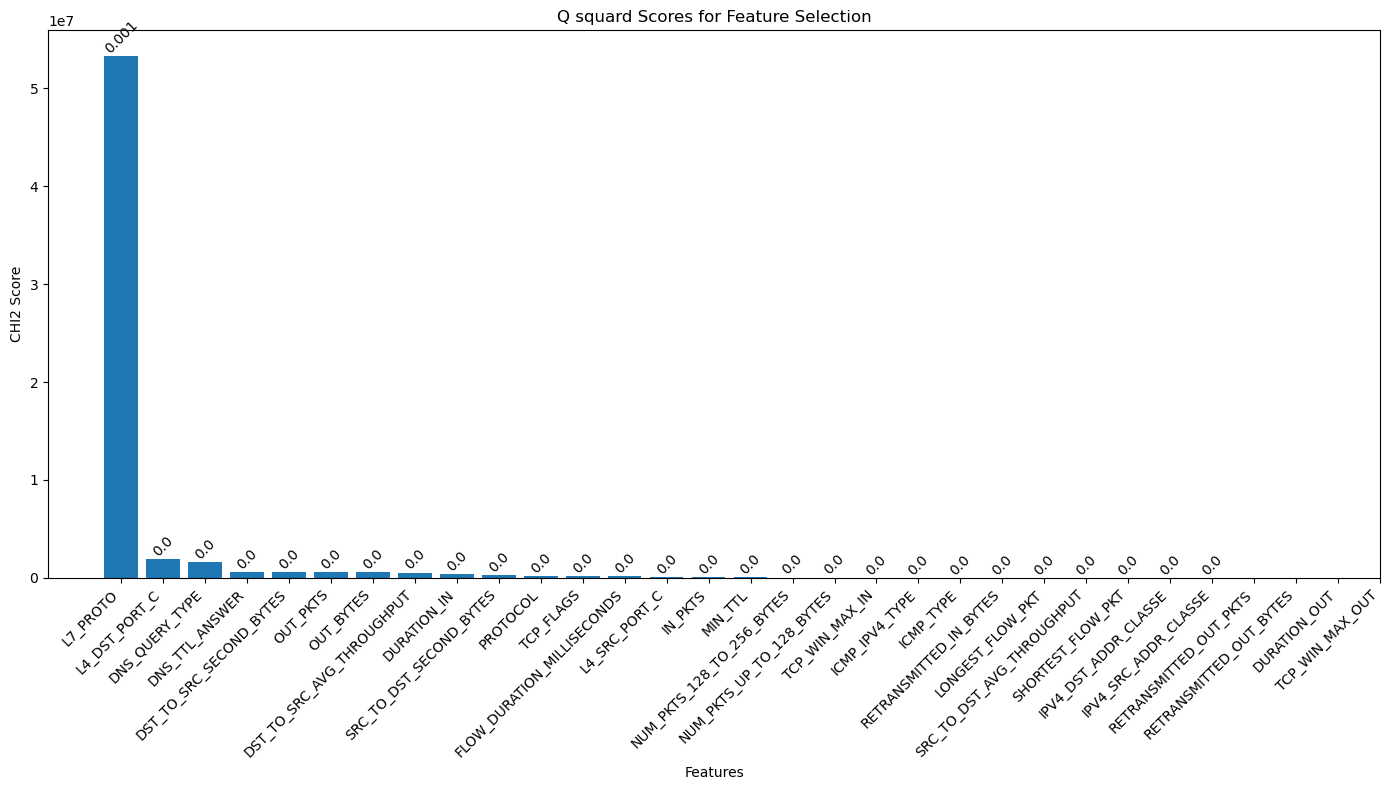

In [50]:
import matplotlib.pyplot as plt

chi2_scores = -np.sort(-chi2_corr[0])
feature_names_chi2 = columns_ranked_chi2

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(feature_names_chi2)), chi2_scores, align='center')
plt.xticks(range(len(feature_names_chi2)), feature_names_chi2, rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("CHI2 Score")
plt.title("Q squard Scores for Feature Selection")

# Add MI score values at the top of each bar
for bar, score in zip(bars, mi_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(score, 3),
             ha='center', va='bottom', rotation=45)

plt.tight_layout()
plt.show()

In [32]:
X_MI_20 = X[columns_ranked_mi[:7]]
X_MI_50 =  X[columns_ranked_mi[:18]]
X_MI_80 =  X[columns_ranked_mi[:25]]

list_dummy_20 = list(set( list(X_MI_20.columns)).intersection(dummy_feature))
list_dummy_50 = list(set( list(X_MI_50.columns)).intersection(dummy_feature))
list_dummy_80 = list(set( list(X_MI_80.columns)).intersection(dummy_feature))


X_MI_20 = pd.get_dummies(X_MI_20, columns=list_dummy_20)
X_MI_50 = pd.get_dummies(X_MI_50, columns=list_dummy_50)
X_MI_80 = pd.get_dummies(X_MI_80, columns=list_dummy_80)

## mRMR

In [33]:
from mrmr import mrmr_classif
selected_features_20 = mrmr_classif(X=X, y=y_b, K=7)
selected_features_50 = mrmr_classif(X=X, y=y_b, K=18)
selected_features_80 = mrmr_classif(X=X, y=y_b, K=25)

100%|███████████████████████████████████████████| 25/25 [01:14<00:00,  2.98s/it]


In [34]:
X_mrmr_80 = X[selected_features_80]
X_mrmr_50 = X[selected_features_50]
X_mrmr_20 = X[selected_features_20]

list_dummy_20 = list(set( list(X_mrmr_20.columns)).intersection(dummy_feature))
list_dummy_50 = list(set( list(X_mrmr_50.columns)).intersection(dummy_feature))
list_dummy_80 = list(set( list(X_mrmr_80.columns)).intersection(dummy_feature))

X_mrmr_20 = pd.get_dummies(X_mrmr_20, columns=list_dummy_20)
X_mrmr_50 = pd.get_dummies(X_mrmr_50, columns=list_dummy_50)
X_mrmr_80 = pd.get_dummies(X_mrmr_80, columns=list_dummy_80)

In [35]:
selected_features_80

['DNS_QUERY_TYPE',
 'DST_TO_SRC_AVG_THROUGHPUT',
 'IPV4_SRC_ADDR_CLASSE',
 'IPV4_DST_ADDR_CLASSE',
 'MIN_TTL',
 'SRC_TO_DST_SECOND_BYTES',
 'DNS_TTL_ANSWER',
 'OUT_BYTES',
 'OUT_PKTS',
 'DST_TO_SRC_SECOND_BYTES',
 'IN_PKTS',
 'L4_SRC_PORT_C',
 'DURATION_IN',
 'TCP_FLAGS',
 'FLOW_DURATION_MILLISECONDS',
 'L7_PROTO',
 'L4_DST_PORT_C',
 'NUM_PKTS_128_TO_256_BYTES',
 'PROTOCOL',
 'NUM_PKTS_UP_TO_128_BYTES',
 'ICMP_TYPE',
 'TCP_WIN_MAX_IN',
 'ICMP_IPV4_TYPE',
 'RETRANSMITTED_IN_BYTES',
 'SRC_TO_DST_AVG_THROUGHPUT']

In [34]:
import pickle

class Company(object):
    def __init__(self, name, value):
        self.name = name
        self.value = value

with open('attribute/bot_cat.pkl', 'wb') as outp:
    company1 = Company('mi_class', mi_class)
    pickle.dump(company1, outp, pickle.HIGHEST_PROTOCOL)

    company2 = Company('chi2_corr', chi2_corr)
    pickle.dump(company2, outp, pickle.HIGHEST_PROTOCOL)
    
    company3 = Company('selected_features_80', selected_features_80)
    pickle.dump(company3, outp, pickle.HIGHEST_PROTOCOL)


### Decision Tree

### MI

In [53]:
import json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [ ]:
from joblib import Parallel, delayed
from sklearn import tree
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer,cohen_kappa_score,matthews_corrcoef
import json
import multiprocessing
import os

def my_grid_result_df(clf, hyperparams, data_name, algo_name, X, y):
    scoring = {
        "Accuracy": "accuracy",
        "F1-Score": 'f1',
        "Recall": 'recall',
        "Precision": "precision",
        "MCC": make_scorer(matthews_corrcoef),
        "Kappa": make_scorer(cohen_kappa_score)
    }
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    search = GridSearchCV(clf, hyperparams, scoring=scoring, n_jobs=-1, cv=cv_inner, refit="MCC")
    grid_result = search.fit(X, y)

    json_dump = json.dumps(grid_result.cv_results_, cls=NumpyEncoder)
    os.makedirs(f"./result_bin_bot", exist_ok=True)
    with open(f"./result_bin_bot/{algo_name}__{data_name}.json", "w") as outfile:
        outfile.write(json_dump)

def create_all_result_parallel(clf, algo_name, hyperparams, datasets, y):
    # Use joblib to parallelize across datasets
    def process_dataset(k, v):
        now = datetime.datetime.now()
        print(f'======== process======= dataset : {k} \t time is {now}')
        my_grid_result_df(clf, hyperparams, k, algo_name, v, y)
        now = datetime.datetime.now()
        print(f'======== Done  ======== dataset : {k} \t time is {now}')
        print('\n')

    n_jobs = min(multiprocessing.cpu_count(), len(datasets))
    Parallel(n_jobs=n_jobs)(delayed(process_dataset)(k, v) for k, v in datasets.items())

In [55]:
datasets = {'X_chi2_20':X_chi2_20,
            'X_chi2_50':X_chi2_50,
            'X_chi2_80':X_chi2_80,
            'X_MI_20':X_MI_20,
            'X_MI_50':X_MI_50,
            'X_MI_80':X_MI_80,
            'X_mrmr_20':X_mrmr_20,
            'X_mrmr_50':X_mrmr_50,
            'X_mrmr_80':X_mrmr_80,
            'X':X}

In [56]:
import datetime
def create_all_result(clf,algo_name,hyperparams,datasets,y):
    for k,v in datasets.items():
        now = datetime.datetime.now()
        print(f'======== process======= dataset : {k} \t time is {now}')
        my_grid_result_df(clf,hyperparams,k,algo_name,v,y)
        now = datetime.datetime.now()
        print(f'======== Done  ======== dataset : {k} \t time is {now}')
        print('\n')


# Decision Tree

In [ ]:
clf = tree.DecisionTreeClassifier()
hyperparams = {}
create_all_result_parallel(clf, 'DecisionTreeClassifier', hyperparams, datasets, y_b)

======== process======= dataset : X_chi2_20 	 time is 2023-03-10 23:26:21.846575
======== Done  ======== dataset : X_chi2_20 	 time is 2023-03-10 23:28:18.161639


======== process======= dataset : X_chi2_50 	 time is 2023-03-10 23:28:18.161639
======== Done  ======== dataset : X_chi2_50 	 time is 2023-03-10 23:40:08.050286


======== process======= dataset : X_chi2_80 	 time is 2023-03-10 23:40:08.050286
======== Done  ======== dataset : X_chi2_80 	 time is 2023-03-10 23:57:01.390822


======== process======= dataset : X_MI_20 	 time is 2023-03-10 23:57:01.390822
======== Done  ======== dataset : X_MI_20 	 time is 2023-03-11 00:00:19.217504


======== process======= dataset : X_MI_50 	 time is 2023-03-11 00:00:19.217504
======== Done  ======== dataset : X_MI_50 	 time is 2023-03-11 00:09:23.537041


======== process======= dataset : X_MI_80 	 time is 2023-03-11 00:09:23.537041
======== Done  ======== dataset : X_MI_80 	 time is 2023-03-11 00:24:22.055865


======== process======= data

### AdaBoostClassifier, GradientBoostingClassifier


In [58]:
def print_skip():
    print('\n')
    print('*************** \t ******************* \t ****************')
    print('*************** \t ******************* \t ****************')
    print('\n')

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Define classifiers and their hyperparameters
classifiers = [
    (GradientBoostingClassifier(random_state=0), 'GradientBoostingClassifier', {'n_estimators':[50, 100, 150, 200]}),
    (AdaBoostClassifier(random_state=0), 'AdaBoostClassifier', {'n_estimators':[50, 100, 150, 200]}),
    (XGBClassifier(random_state=0), 'XGBClassifier', {'n_estimators':[50, 100, 150, 200]}),
    (LGBMClassifier(random_state=0), 'LGBMClassifier', {'n_estimators':[50, 100, 150, 200]}),
    (CatBoostClassifier(random_state=0, verbose=0), 'CatBoostClassifier', {'iterations':[50, 100, 150, 200]})
    # Note: CatBoost uses 'iterations' instead of 'n_estimators'
    # Add more classifiers as needed
    ]

for clf, name, params in classifiers:
    print(f'======================= {name} =====================')
    create_all_result_parallel(clf, name, params, datasets, y_b)
    print('\n*************** \t ******************* \t ****************\n')

======================= GradientBoostingClassifier =====================
======== process======= dataset : X_chi2_20 	 time is 2023-03-11 01:10:32.429154
======== Done  ======== dataset : X_chi2_20 	 time is 2023-03-11 03:55:04.211794


======== process======= dataset : X_chi2_50 	 time is 2023-03-11 03:55:04.211794
======== Done  ======== dataset : X_chi2_50 	 time is 2023-03-11 17:23:33.850099


======== process======= dataset : X_chi2_80 	 time is 2023-03-11 17:23:33.850099
======== Done  ======== dataset : X_chi2_80 	 time is 2023-03-12 07:14:07.839351


======== process======= dataset : X_MI_20 	 time is 2023-03-12 07:14:07.933078
======== Done  ======== dataset : X_MI_20 	 time is 2023-03-12 09:46:43.278586


======== process======= dataset : X_MI_50 	 time is 2023-03-12 09:46:43.278586
======== Done  ======== dataset : X_MI_50 	 time is 2023-03-12 18:20:19.696750


======== process======= dataset : X_MI_80 	 time is 2023-03-12 18:20:19.696750


In [46]:
#   XGB_200


# Best Model using  descritization  20  X_chi2_20  Chi2+CATB_150 & Chi2+XGB_200 ||| 50  mRMR+XGB_200  X_mRMR_50 ||  80 mRMR+XGB_150  X_mrmr_80  ||  100 XGB_200  X

import xgboost as xgb

# Train your model (example)
model = xgb.XGBClassifier(n_estimators=200)
model.fit(X, y_b)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [49]:
from catboost import CatBoostClassifier

# Train your model (example)
model = CatBoostClassifier(
    iterations=150,       # equivalent to n_estimators
    verbose=0             # silence training output
)

model.fit(X_chi2_20, y_b)

In [50]:
import joblib

# Save
joblib.dump(model, "CTB_150_Chi2_20.pkl")

['CTB_150_Chi2_20.pkl']

In [48]:
print(list(X.iloc[0].values))
print(list(X.iloc[345].values))
print(list(X.iloc[6546].values))
print(list(X.iloc[23].values))
print(list(X.iloc[87].values))
print(list(X.iloc[9].values))
print(list(X.iloc[678].values))
print(list(X.iloc[0].values))
print(list(X.iloc[235].values))
print(list(X.iloc[98].values))

[np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(4), np.int64(6), np.int64(0), np.int64(1), np.int64(2), np.int64(2), np.int64(5), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(2), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(6), np.int64(7), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(3), np.int64(3)]
[np.int64(2), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(9), np.int64(0), np.int64(1), np.int64(2), np.int64(2), np.int64(6), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(2), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(6), np.int64(7), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(2), np.int64(0), np.int64(3), np.int64(3)]
[np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(7), np.int64(3), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(3), np.int64(0), np.int64(0), np.int64(0), np.int64(